In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

from tqdm.notebook import tqdm

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
import datetime as dt
from tools import *
datadir = '/'.join(os.getcwd().split('/')[:-1])+"/2_Data/"
# Functions
@logger
def select_meter(df, meter=0): # Electricity = 0
    return df[df.meter==0].drop(columns=['meter'])

@logger
def drop_outliers(df, threshold=5000): # does this threshold makes sense?
    return df[df.meter_reading<threshold]

@logger
def to_datetime(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    return df

def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [3]:
# Load data into DataFrames and reduce memory
df_meta_raw = pd.read_csv(datadir+'building_metadata.csv')
df_raw = pd.read_csv(datadir+'train.csv')
df_weather_raw = pd.read_csv(datadir+'weather_train.csv')

df = (df_raw.pipe(start_pipeline)
            .pipe(reduce_mem_usage)
            .pipe(select_meter) # only electricity
            #.pipe(drop_outliers) # check this threshold, we haven't done any visual check
            .pipe(to_datetime))
df_meta = (df_meta_raw.pipe(start_pipeline)
                      .pipe(reduce_mem_usage))
df_weather = (df_weather_raw.pipe(start_pipeline)
                            .pipe(reduce_mem_usage)
                            .pipe(to_datetime))

start_pipeline took 0:00:00 secs, shape(20216100, 4)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
reduce_mem_usage took 0:00:00 secs, shape(20216100, 4)
select_meter took 0:00:00 secs, shape(12060910, 3)
to_datetime took 0:00:00 secs, shape(12060910, 3)
start_pipeline took 0:00:00 secs, shape(1449, 6)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
reduce_mem_usage took 0:00:00 secs, shape(1449, 6)
start_pipeline took 0:00:00 secs, shape(139773, 9)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
reduce_mem_usage took 0:00:00 secs, shape(139773, 9)
to_datetime took 0:00:00 secs, shape(139773, 9)


In [4]:
# Filter raw datasets to include only households
df_meta = df_meta[df_meta.primary_use.eq('Lodging/residential')]
hh_id = df_meta.building_id.unique()
df = df[df.building_id.isin(hh_id)]
hh_id2 = df.building_id.unique() # repeat because 2 ids are missing from df_meta
df_meta = df_meta[df_meta.building_id.isin(hh_id2)]
hh_site_id = df_meta.site_id.unique()
df_weather = df_weather[df_weather.site_id.isin(hh_site_id)]

In [5]:
# Join datasets
df = df.set_index('building_id').join(df_meta.set_index('building_id'), how='inner')
df = df.reset_index() # to keep building_id
df = df.set_index('timestamp').merge(df_weather.set_index('timestamp'),
                                    on=['site_id', 'timestamp'],
                                    how='left')

#Drop unused variables
df = df.drop(columns=['primary_use',
                      'floor_count',
                      'cloud_coverage',
                      'precip_depth_1_hr',
                      'wind_direction'])

In [6]:
# Sample from DataFrame
df_test = df.dropna(axis=0)
df_small = df_test.sample(frac=0.01)
df_small['week'] = df_small.index.week
df_small['day'] =  df_small.index.weekday

In [7]:
# Prepare matrix with time features
X_time = np.concatenate([pd.get_dummies(df_small[x]) for x in ["week", "day"]], axis=1)
X_site_id = pd.get_dummies(df_small.site_id)
X_rest = df_small.drop(columns=['meter_reading', 'site_id', 'week', 'day'])

# Scale X_rest
X_rest -= X_rest.mean()
X_rest /= X_rest.std()

In [8]:
# Join matrices
X = np.concatenate([X_time, X_rest], axis=1)
print(X.shape)

(6607, 67)


In [91]:
# Transform target variable
y = df_small.meter_reading.values
mean = y.mean()
std = y.std()
y = (y - mean)/std

In [117]:
# Train/test split
train_perc = 0.75 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
#create a mapping between building_ids and individual ids, because we need a continuous range of ids
mapping = {key: value for value, key in enumerate(set(df_small.building_id))}
inds = torch.LongTensor([mapping[h_id] for h_id in df_small.building_id])
ind_train = inds[ix_train]
ind_test = inds[ix_test]
#create a mapping for site_id because we need a continuous range of ids
site_mapping = {key: value for value, key in enumerate(set(df_small.site_id))}
sites = torch.LongTensor([site_mapping[h_id] for h_id in df_small.site_id])
sites_train = sites[ix_train]

sites_test = sites[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))


num train: 4955
num test: 1652


In [118]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [119]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 5.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            5.*torch.ones(X.shape[1])))    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

In [154]:
# Define guide function
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in tqdm(range(n_steps)):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 14116.3
[1000] ELBO: 10576.7
[2000] ELBO: 7499.8
[3000] ELBO: 6128.7
[4000] ELBO: 5998.1
[5000] ELBO: 5982.5
[6000] ELBO: 5976.7
[7000] ELBO: 5973.6
[8000] ELBO: 5976.0
[9000] ELBO: 5975.7



In [155]:
from pyro.infer import Predictive

# Use predictive from pyro
predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("beta", "alpha"))
samples = predictive(X_train_torch, y_train_torch)

In [156]:
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
beta_samples.shape, alpha_samples.shape

((1000, 67), (1000, 1))

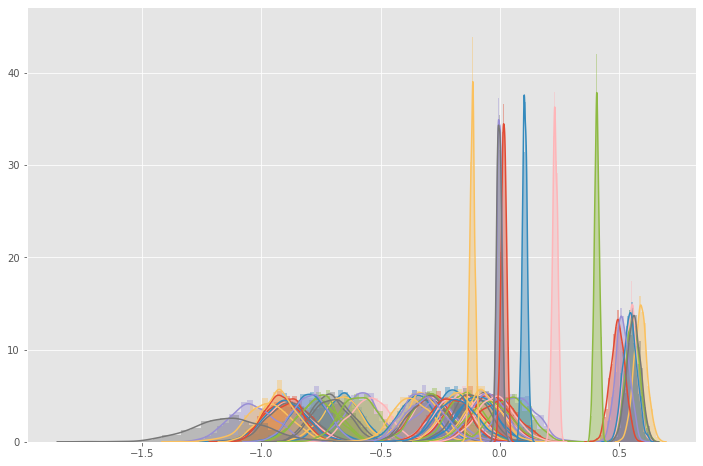

In [157]:
for i in range(X.shape[1]):
    sns.distplot(beta_samples[:,i])

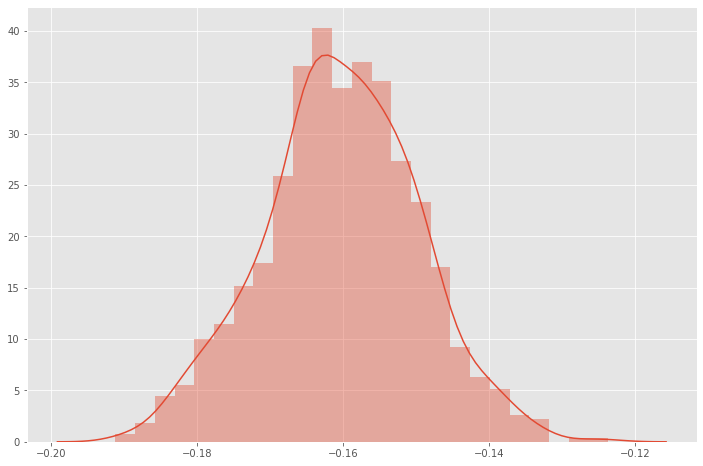

In [158]:
sns.distplot(alpha_samples)

In [159]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [160]:
# make predictions for test set
y_hat = alpha_hat + np.dot(X_test, beta_hat.T)

In [161]:
# convert back to the original scale
preds = y_hat * std + mean
y_true = y_test * std + mean

In [162]:
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.657
MAE: 84.961
RMSE: 111.268
R2: 0.430


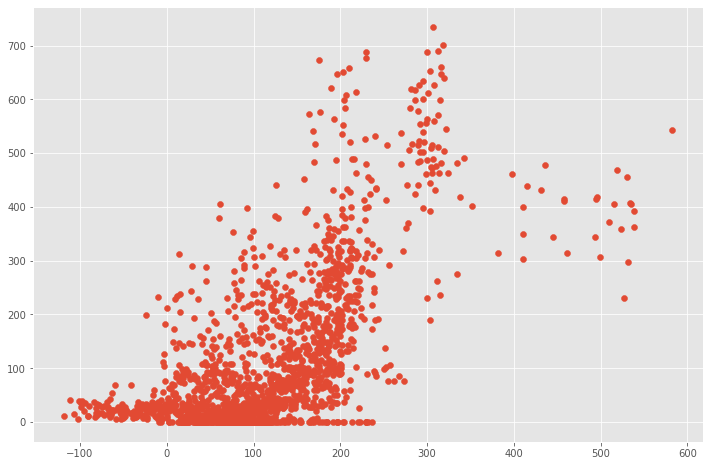

In [163]:
plt.scatter(preds.flatten(), y_true.flatten())

Extending the simple linear model, we build a hierachical model, by assuming different biases for each household.

In [134]:
def hierarchical_model(X, ind, n_households, site, n_sites, obs=None):
    N, M = X.shape
    
    alpha_mu = pyro.sample("alpha_mu", dist.Normal(0., 5.))
    alpha_sigma = pyro.sample("alpha_sigma", dist.HalfCauchy(5.))
    
    #beta = pyro.sample("beta", dist.Normal(torch.zeros(M), 5.*torch.ones(M)))
    beta_mu = pyro.sample("beta_mu", dist.Normal(torch.zeros(M), 5.*torch.ones(M)))
    beta_sigma = pyro.sample("beta_sigma", dist.HalfCauchy(5.*torch.ones(M)))
    
    beta = pyro.sample("beta", dist.Normal(torch.zeros(M), 5.*torch.ones(M)))

    
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance

#    # if we want different betas for each site    
#    with pyro.plate("areas", n_areas):
#        beta = pyro.sample("beta", dist.Normal(beta_mu, beta_sigma).to_event(1))
    
    # if we want different alphas for each household?    
    with pyro.plate("sites", n_sites):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mu, alpha_sigma).to_event(0))
#        sigma = pyro.sample("sigma", dist.HalfCauchy(5.).to_event(0))                   # Prior for the variance for each household ??? Makes Sense?

    
    with pyro.plate("data", N):
        y = pyro.sample("y", dist.Normal(alpha[site]+ X.matmul(beta.T), sigma), obs=obs)
        
    return y


Another approach would be to take different beta's for each household but this is too expensive in terms for speed for now. Maybe try with different set of beta's for areas instead of households.

In [135]:
n_households = len(df_small.building_id.unique()) # one cat for each household
n_areas = len(set(df_small.site_id))

In [179]:
# Define guide function
guide = AutoMultivariateNormal(hierarchical_model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=4)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in tqdm(range(n_steps)):
    elbo = svi.step(X_train_torch, ind_train, n_households, sites_train, n_areas, y_train_torch)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 17096.9
[1000] ELBO: 11884.7
[2000] ELBO: 9076.0
[3000] ELBO: 6549.0
[4000] ELBO: 6473.7
[5000] ELBO: 6217.9
[6000] ELBO: 6157.0
[7000] ELBO: 6103.0
[8000] ELBO: 6082.2
[9000] ELBO: 6250.7
[10000] ELBO: 6565.1
[11000] ELBO: 6102.0
[12000] ELBO: 6117.4
[13000] ELBO: 6165.0
[14000] ELBO: 6336.0
[15000] ELBO: 6290.3
[16000] ELBO: 6217.2
[17000] ELBO: 6129.4
[18000] ELBO: 6431.7
[19000] ELBO: 6228.3



In [180]:
from pyro.infer import Predictive

# Use predictive from pyro
predictive = Predictive(hierarchical_model, guide=guide, num_samples=1000,
                        return_sites=("beta", "alpha", "alpha_mu", "alpha_sigma"))
samples = predictive(X_train_torch,ind_train, n_households, sites_train, n_areas, y_train_torch)

In [181]:
beta_samples = samples["beta"].detach().numpy()
alpha_samples = samples["alpha"].detach().numpy()
alpha_mu_samples = samples["alpha_mu"].detach().numpy()
alpha_sigma_samples = samples["alpha_sigma"].detach().numpy()


In [182]:
beta_samples.shape, alpha_samples.shape

((1000, 67), (1000, 6))

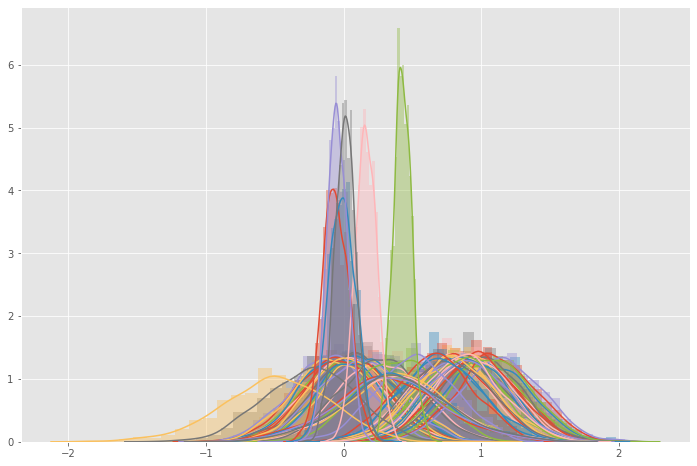

In [183]:
for i in range(X.shape[1]):
    sns.distplot(beta_samples[:,i])

IndexError: index 6 is out of bounds for axis 1 with size 6

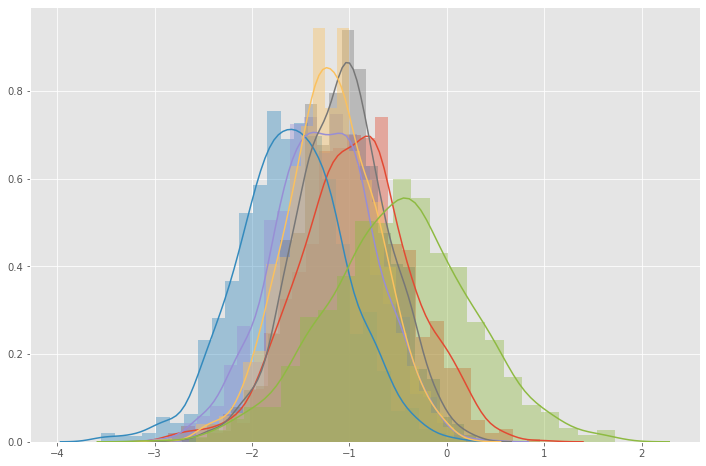

In [184]:
for i in range(X.shape[1]):
    sns.distplot(alpha_samples[:,i])

In [185]:
# extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0).detach().numpy()
beta_hat = samples["beta"].mean(axis=0).detach().numpy()

In [186]:
# make predictions for test set
y_hat = alpha_hat[sites_test] + np.dot(X_test, beta_hat.T)

In [187]:
y_hat

array([-0.04650353, -0.63314318, -0.69948537, ..., -0.52531295,
        0.33039585,  1.00121882])

In [188]:
# convert back to the original scale
preds = y_hat * std + mean
y_true = y_test * std + mean

In [189]:
corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.684
MAE: 82.971
RMSE: 107.688
R2: 0.466


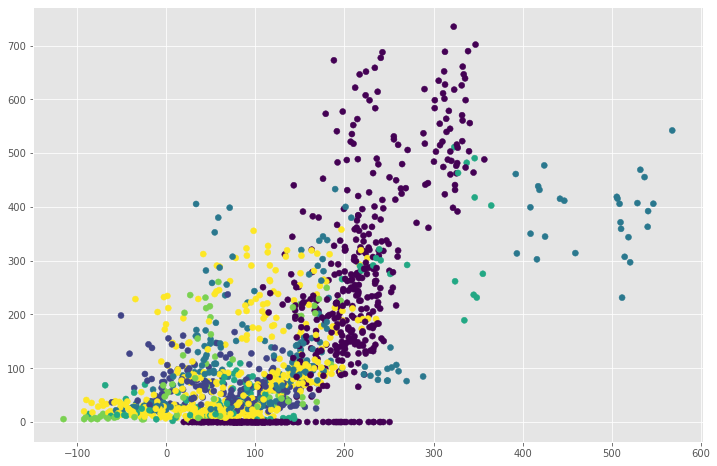

In [190]:
plt.scatter(preds.flatten(), y_true.flatten(), c=sites_test)